<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/No_supervisados_Ejercicio_7_kmeans_mall_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No supervisados - Ejercicio 7: kmeans_mall_customers.ipynb

Este notebook es un **I do** (todo resuelto).

## Objetivos

- Cargar y explorar el dataset *Mall Customers*.
- Preprocesar (encoding y escalado) y elegir features para clustering.
- Determinar un `k` razonable con elbow + silhouette.
- Entrenar KMeans y comparar resultados con DBSCAN (ejemplo práctico).
- Interpretar los centroides y perfilar segmentos para acciones de negocio.

## Descripción del dataset

Mall Customers: típico dataset para segmentación de clientes con columnas como `CustomerID`, `Gender`, `Age`, `Annual Income (k$)`, `Spending Score (1-100)`. Fuente típica: Kaggle. En este caso lo tenemos subido a nuestro repositorio.

In [ ]:
# 1) Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
sns.set(style='whitegrid')
np.random.seed(42)

In [ ]:
# 2) Cargar dataset
url = 'https://raw.githubusercontent.com/dtoralg/INESDI_Data-Science_ML_IA/refs/heads/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/Mall_Customers.csv'

df = pd.read_csv(url)
print('Cargado desde', url)


Cargado desde https://raw.githubusercontent.com/dtoralg/INESDI_Data-Science_ML_IA/refs/heads/main/%5B04%5D%20-%20Modelos%20No%20Supervisados/Mall_Customers.csv


In [ ]:
# 3) EDA rápido
print('Nulos por columna:')
print((df.isnull().mean()*100).round(2))
print('\nTipos de columnas:')
print(df.dtypes)
print('\nDescripción:')
display(df.describe(include='all'))

Nulos por columna:
CustomerID                0.0
Genre                     0.0
Age                       0.0
Annual Income (k$)        0.0
Spending Score (1-100)    0.0
dtype: float64

Tipos de columnas:
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Descripción:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


### Nota sobre selección de variables

Para modeling/clustering seleccionaremos las columnas numéricas relevantes.

En esta práctica recomiendo usar `Age`, `Annual Income (k$)` y `Spending Score (1-100)`.

Si hubiera columnas categóricas relevantes, las codificamos. A continuación codificamos `Gender` como ejemplo y creamos X_num con las features seleccionadas.

In [ ]:
# 4) Preparación: encoding y selección de features
df_proc = df.copy()
if 'Gender' in df_proc.columns:
    le = LabelEncoder()
    df_proc['Gender_enc'] = le.fit_transform(df_proc['Gender'].astype(str))

features = []
for c in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    if c in df_proc.columns:
        features.append(c)

print('Features seleccionadas:', features)
X = df_proc[features].copy()


display(X.head())

Features seleccionadas: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


## 5) Escalado

KMeans y DBSCAN son sensibles a la escala. Estandarizamos las features antes de aplicar algoritmos de distancia.

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
display(X_scaled.describe().round(2).T)

,count,mean,std,min,25%,50%,75%,max
Age,200.0,-0.0,1.0,-1.50,-0.72,-0.20,0.73,2.24
Annual Income (k$),200.0,-0.0,1.0,-1.74,-0.73,0.04,0.67,2.92
Spending Score (1-100),200.0,-0.0,1.0,-1.91,-0.60,-0.01,0.89,1.89


## 6) Determinar k: Elbow (inertia) + Silhouette (búsqueda manual)

Probaremos varios `k` (2..8) y miraremos inertia y silhouette score para orientar la elección.

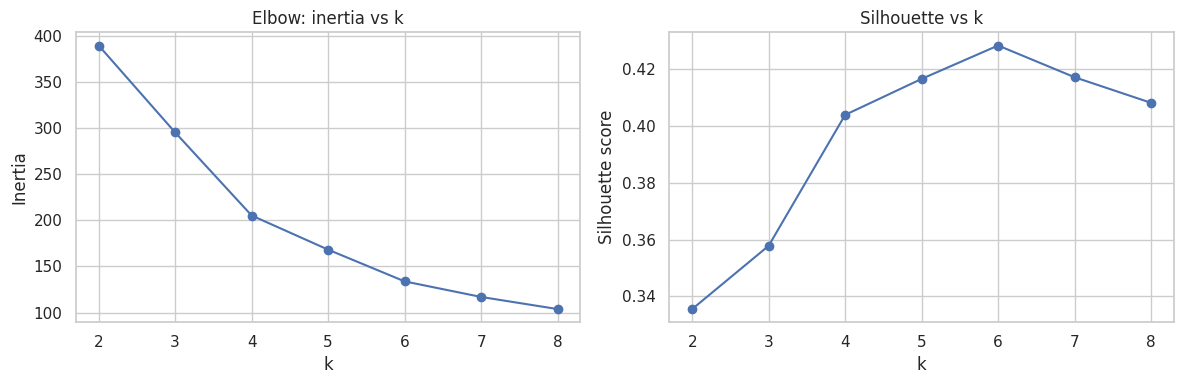

Silhouette scores per k:
2 0.335
3 0.358
4 0.404
5 0.417
6 0.428
7 0.417
8 0.408


In [ ]:
inertias = []
sil_scores = []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    preds = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, preds))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow: inertia vs k')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette vs k')
plt.tight_layout()
plt.show()

print('Silhouette scores per k:')
for k, s in zip(K_range, sil_scores):
    print(k, round(s,3))

## 7) Entrenar KMeans con k elegido y perfilar clusters

Elegimos un `k` razonable según elbow+silhouette. Tomamos k=6; ajústalo si tu análisis sugiere otro valor.

In [ ]:
# Elegir k (ajusta si quieres)
k_chosen = 5
print('k elegido:', k_chosen)

kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)
X_scaled['cluster_km'] = labels_km
df_proc['cluster_km'] = labels_km

print('\nTamaño de clusters:')
print(pd.Series(labels_km).value_counts().sort_index())

# Perfilado: medias por cluster (sobre columnas originales para interpretación)
profile = df_proc.groupby('cluster_km')[features].mean()
display(profile.round(2))

k elegido: 5

Tamaño de clusters:
0    20
1    54
2    40
3    39
4    47
Name: count, dtype: int64


,Age,Annual Income (k$),Spending Score (1-100)
cluster_km,,,
0,46.25,26.75,18.35
1,25.19,41.09,62.24
2,32.88,86.10,81.53
3,39.87,86.10,19.36
4,55.64,54.38,48.85


## 8) Visualizar clusters en 2D con PCA

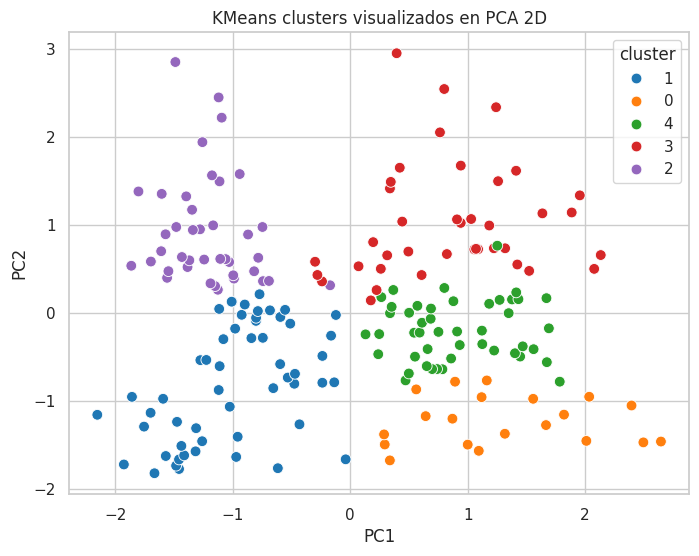

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


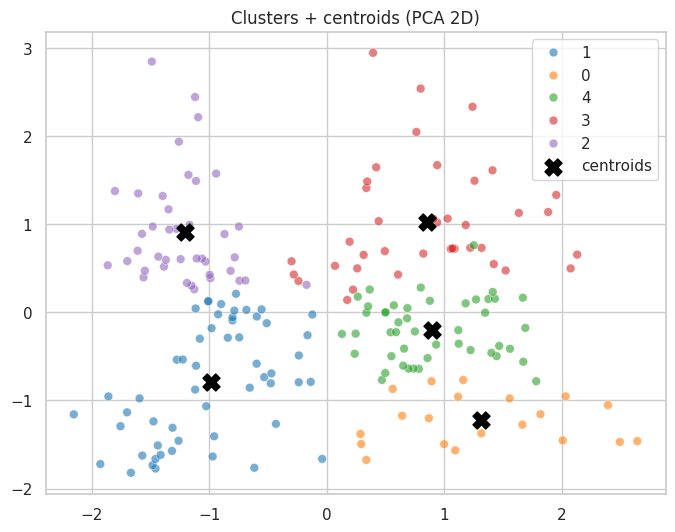

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled[features])
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km.astype(str), palette='tab10', s=60)
plt.title('KMeans clusters visualizados en PCA 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()

# Centroides proyectados
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km.astype(str), palette='tab10', s=40, alpha=0.6)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=150, marker='X', label='centroids')
plt.title('Clusters + centroids (PCA 2D)')
plt.legend()
plt.show()

## 9) Comparación práctica: DBSCAN

DBSCAN detecta clusters de forma y densidad arbitrarias y outliers. Aquí mostramos un ejemplo práctico. Ajusta `eps` y `min_samples` según el k-distance plot o inspección visual.

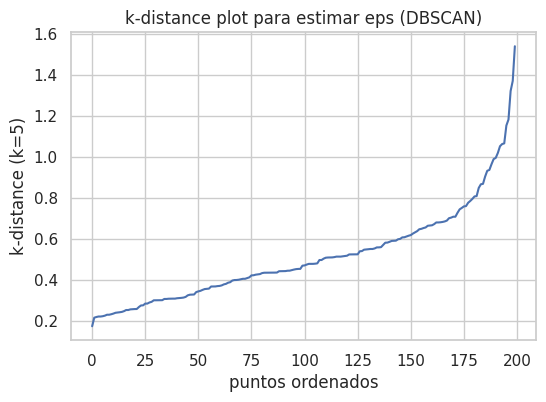

In [ ]:
# k-distance plot para estimar eps
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_scaled[features])
distances, indices = nbrs.kneighbors(X_scaled[features])
distances = np.sort(distances[:, -1])
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.ylabel('k-distance (k=5)')
plt.xlabel('puntos ordenados')
plt.title('k-distance plot para estimar eps (DBSCAN)')
plt.show()

Etiquetas DBSCAN (incluye -1 para noise): [-1  0  1]

Tamaño por etiqueta:
 0    137
 1     35
-1     28
Name: count, dtype: int64
Adjusted Rand Index (KMeans vs DBSCAN): 0.245


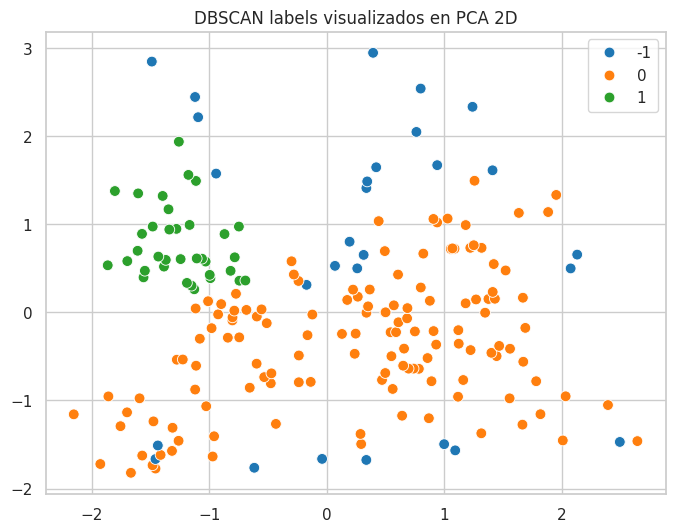

In [ ]:
# Ejecutar DBSCAN con ejemplos de parámetros
from sklearn.metrics import adjusted_rand_score
db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled[features])
df_proc['cluster_db'] = labels_db
print('Etiquetas DBSCAN (incluye -1 para noise):', np.unique(labels_db))
print('\nTamaño por etiqueta:')
print(pd.Series(labels_db).value_counts())

# Comparación rápida con KMeans (ajustada para entender similitud)
if len(np.unique(labels_db)) > 1:
    ari = adjusted_rand_score(labels_km, labels_db)
    print('Adjusted Rand Index (KMeans vs DBSCAN):', round(ari,3))

# Visualizar DBSCAN en PCA 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_db.astype(str), palette='tab10', s=60)
plt.title('DBSCAN labels visualizados en PCA 2D')
plt.show()

## 10) Acciones sobre segmentos (profiling)

Interpretamos los clusters KMeans (y DBSCAN) en términos de las variables originales para proponer acciones de negocio (p.ej. campañas para clientes de alto gasto o jóvenes de bajo gasto).

In [ ]:
# Mostrar counts y perfiles combinados
print('KMeans - counts:')
display(pd.Series(labels_km).value_counts().sort_index())
print('\nDBSCAN - counts (incluye -1 noise):')
display(pd.Series(labels_db).value_counts().sort_index())

print('\nPerfil KMeans (medias originales):')
display(df_proc.groupby('cluster_km')[features].mean().round(2))

if 'cluster_db' in df_proc.columns:
    print('\nPerfil DBSCAN (medias originales, excluyendo noise -1):')
    display(df_proc[df_proc['cluster_db']!=-1].groupby('cluster_db')[features].mean().round(2))

KMeans - counts:


,count
0,20
1,54
2,40
3,39
4,47



DBSCAN - counts (incluye -1 noise):


,count
-1,28
0,137
1,35



Perfil KMeans (medias originales):


,Age,Annual Income (k$),Spending Score (1-100)
cluster_km,,,
0,46.25,26.75,18.35
1,25.19,41.09,62.24
2,32.88,86.10,81.53
3,39.87,86.10,19.36
4,55.64,54.38,48.85



Perfil DBSCAN (medias originales, excluyendo noise -1):


,Age,Annual Income (k$),Spending Score (1-100)
cluster_db,,,
0,40.97,51.61,45.34
1,32.74,82.54,82.80


## 11) Conclusión

- KMeans ofrece clusters con centroides interpretables y es fácil de perfilar; requiere elegir `k` y puede fallar con formas no convexas.
- DBSCAN detecta ruido y clusters de forma arbitraria, pero es sensible a `eps` y `min_samples`.
- Combinar PCA para visualización con KMeans/DBSCAN es una práctica útil para entender resultados.